# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [2]:
# Import libraries
# Import essential libraries
import pathlib
import numpy as np
import pandas as pd
import os

# Import Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

#Import Image processing libraries
import PIL
import glob
from PIL import Image

#Import Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Model evaluation libraries
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn

#Import zip utility
import zipfile

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [3]:
# Define a function to load data and aggregate them
def createSingleDataFrame(file_arr):

    # Read and concatenate all data files
    merged_df = pd.concat((pd.read_csv(f) for f in file_arr), ignore_index=True)
    print(f"Total files merged: {len(file_arr)}")

    return merged_df

In [5]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
file_list = [
    "AMZN_stocks_data.csv",
    "GOOGL_stocks_data.csv",
    "IBM_stocks_data.csv",
    "MSFT_stocks_data.csv"
]
stock_df = createSingleDataFrame(file_list)
#stock_df.count

Total files merged: 4


In [6]:
# View specifics of the data
print("****SPECIFICS OF DATA**** \n"+ '-'*30)
print("Stock dataframe Shape: ", stock_df. shape)
print("\nStock Info:")
print(stock_df.info())
print("\nData Description:\n")
print(stock_df.describe())

****SPECIFICS OF DATA**** 
------------------------------
Stock dataframe Shape:  (12077, 7)

Stock Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB
None

Data Description:

               Open          High           Low         Close        Volume
count  12076.000000  12077.000000  12076.000000  12077.000000  1.207700e+04
mean     227.387118    229.422254    225.203189    227.380960  1.671763e+07
std      236.938260    238.568485    234.981015    236.851101  2.570572e+07
min       15.200000     15.620000     14.870000     15.15000

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [7]:
# Handle Missing Values
print("Null Value Present: ", stock_df.isnull().values.any())
stock_df.head()

Null Value Present:  True


,Date,Open,High,Low,Close,Volume,Name
0,03-01-2006,47.47,47.85,46.25,47.58,7582127,AMZN
1,04-01-2006,47.48,47.73,46.69,47.25,7440914,AMZN
2,05-01-2006,47.16,48.20,47.11,47.65,5417258,AMZN
3,06-01-2006,47.97,48.58,47.32,47.87,6154285,AMZN
4,09-01-2006,46.55,47.10,46.40,47.08,8945056,AMZN


In [8]:
#Lets count the number of nulls in each column
def countNull(df, colArray):
    for colName in colArray:
        # Count nulls in a specific column, e.g., 'column_name'
        print(f"Number of nulls in '{colName}': {df[colName].isnull().sum()}")

countNull(stock_df, ['Date','Open','High','Low','Close','Volume','Name'])

Number of nulls in 'Date': 0
Number of nulls in 'Open': 1
Number of nulls in 'High': 0
Number of nulls in 'Low': 1
Number of nulls in 'Close': 0
Number of nulls in 'Volume': 0
Number of nulls in 'Name': 0


In [9]:
#drop the rows where 'Open' and 'Low' are null
stock_df = stock_df.dropna(subset=['Open'])
stock_df = stock_df.dropna(subset=['Low'])

# check the size of dataframe again
stock_df.count()

Date      12076
Open      12076
High      12076
Low       12076
Close     12076
Volume    12076
Name      12076
dtype: int64

In [10]:
#Lets check for nulls again
countNull(stock_df, ['Date','Open','High','Low','Close','Volume','Name'])

Number of nulls in 'Date': 0
Number of nulls in 'Open': 0
Number of nulls in 'High': 0
Number of nulls in 'Low': 0
Number of nulls in 'Close': 0
Number of nulls in 'Volume': 0
Number of nulls in 'Name': 0


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

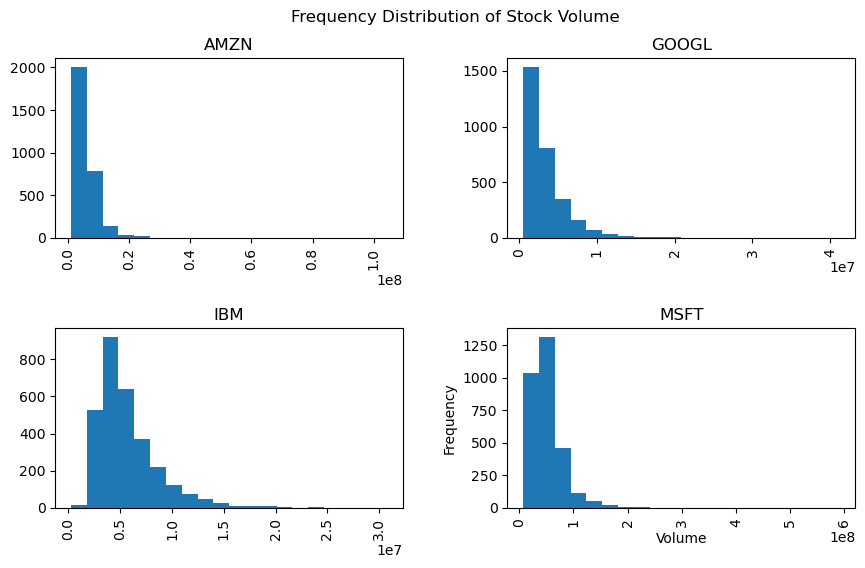

In [12]:
# Frequency distribution of volumes
stock_df.hist(column='Volume', by='Name', bins=20, figsize=(10,6))
plt.suptitle('Frequency Distribution of Stock Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

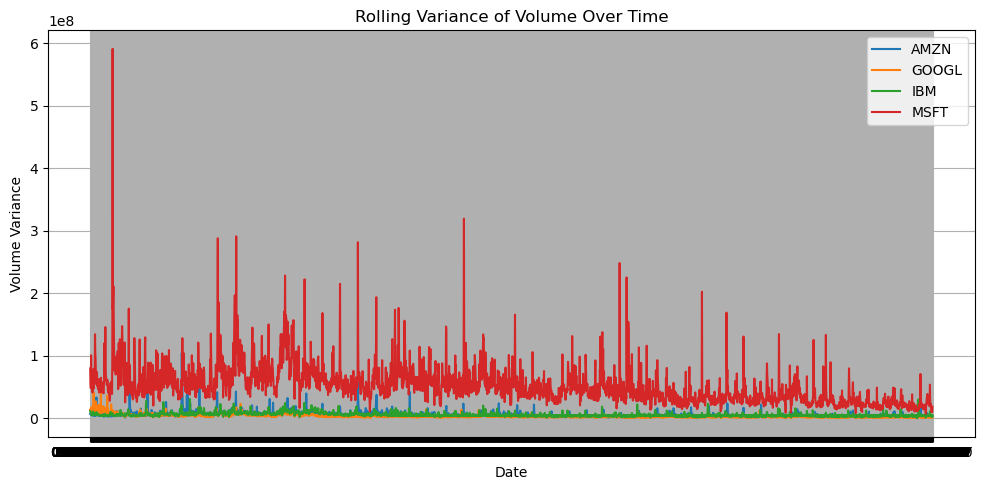

In [13]:
# Stock volume variation over time
plt.figure(figsize=(10, 5))
for name in stock_df['Name'].unique():
    name_df = stock_df[stock_df['Name'] == name]
    plt.plot(name_df['Date'], name_df['Volume'], label=name)

plt.title('Rolling Variance of Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

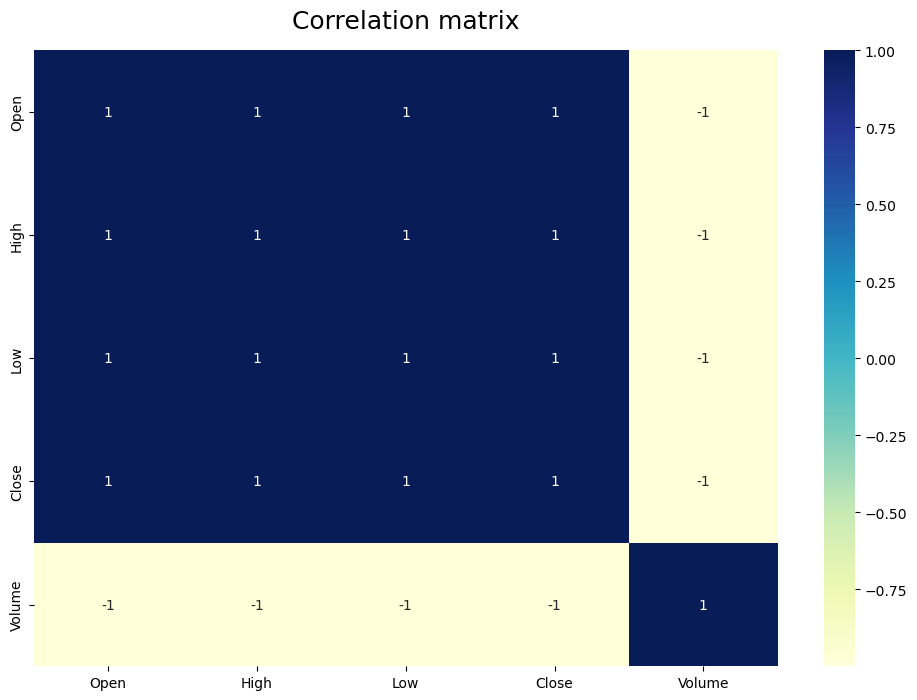

In [22]:
# Analyse correlations
num_dataset = stock_df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(num_dataset.corr(), annot=True, cmap="YlGnBu")
heatmap.set_title('Correlation matrix', fontdict={'fontsize':18}, pad=16)
plt.show()


### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [23]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windows(data, window_size, step_size, target_names):
    X_windows = []
    y_windows = []

    ## lets iterate over data with the step size
    for i in range(0, len(data) - window_size - 1, step_size):
        # Select data for current window
        window = data.iloc[i:i + window_size]

        # create windowed X and y values
        X_window = window[['Open', 'High', 'Low', 'Close', 'Volume']].values
        y_window = data.iloc[i + window_size + 1][['Close']].values  # Target variable(s)

        #This value represents the closing price of Amazon on the day immediately following the first window (day 61). It's stored in y_window as a NumPy array.
        X_windows.append(X_window)
        y_windows.append(y_window)
        #print(data.iloc[61][['Close']].values) index 61st value of close will be targeteted

    return np.array(X_windows),np.array(y_windows)

In [24]:
# Predicting Close price for one of the stocks
target_names = ['AMZN']
window_size = 60  # Set window size of 60 days
step_size = 5   # Step size =5 i.e. move the windows by 5 days

X_windows, y_windows = create_windows(stock_df, window_size, step_size, target_names)

# print the records
print(X_windows[0, 0])
print(X_windows[2, 3])  # Print the fourth element of the third window
X_windows.shape, y_windows.shape

[4.747000e+01 4.785000e+01 4.625000e+01 4.758000e+01 7.582127e+06]
[4.418000e+01 4.475000e+01 4.350000e+01 4.373000e+01 5.752811e+06]


((2403, 60, 5), (2403, 1))

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [25]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows
from sklearn.preprocessing import MinMaxScaler
def scale_Data(X_windows, y_windows):
   # Create scalers for features and target
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    # X_windows.shape, y_windows.shape --> ((2404, 60, 5), (2404, 1))
    # Reshape X_windows for scaling
    num_windows, window_size, num_features = X_windows.shape
    X_reshaped = X_windows.reshape(-1, num_features)

    # Scale using partial_fit to avoid data leakage
    X_scaler.partial_fit(X_reshaped)
    X_scaled = X_scaler.transform(X_reshaped)
    X_scaled = X_scaled.reshape(num_windows, window_size, num_features)

    # Scale target variables
    y_scaler.partial_fit(y_windows)
    y_scaled = y_scaler.transform(y_windows)

    return X_scaled, y_scaled, X_scaler, y_scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [26]:
# Define a function to create input and output data points from the master DataFrame
def create_split(data, target_names, window_size, step_size, test_size=0.2):
    #create windows
    X_windows, y_windows = create_windows(data, window_size, step_size, target_names)

    #scale the windows
    X_scaled, y_scaled, X_scaler, y_scaler = scale_Data(X_windows, y_windows)

    #train-test split
    X_train,X_test,y_train,y_test = train_test_split(X_scaled,y_scaled,test_size=test_size,random_state=42)
    return X_train,X_test,y_train,y_test,X_scaler,y_scaler


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

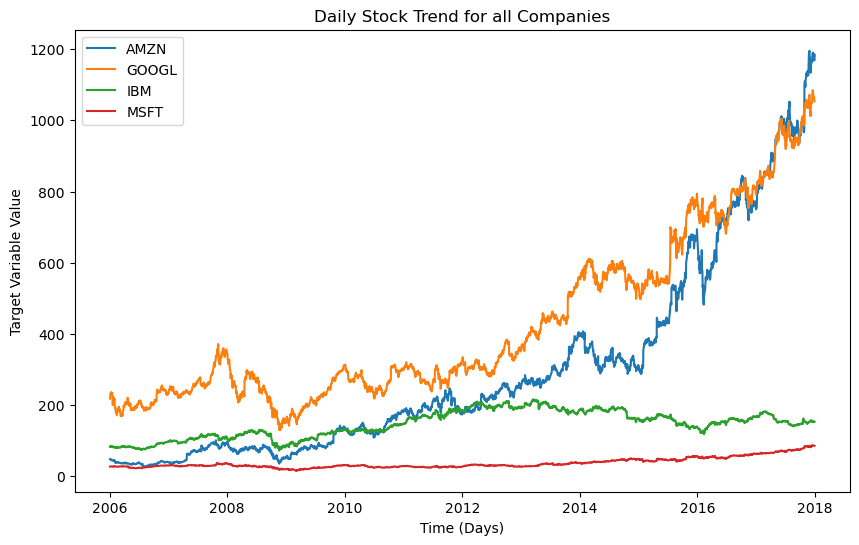

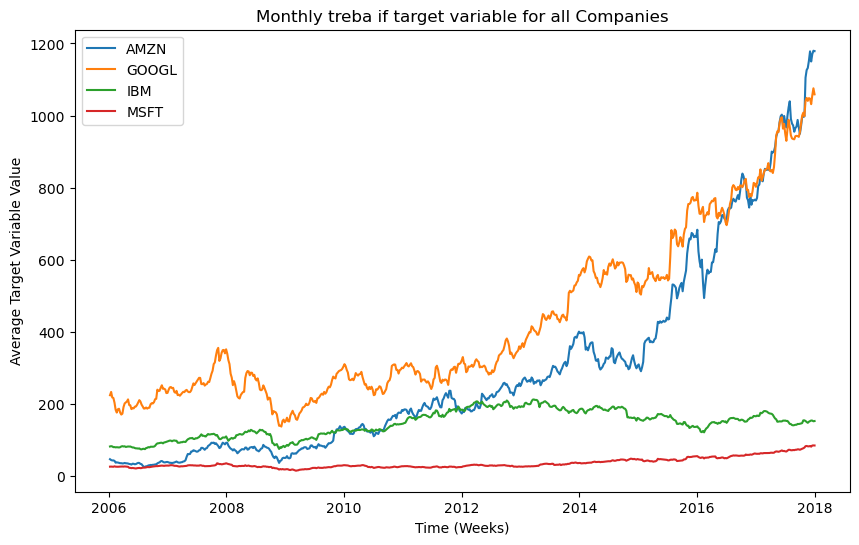

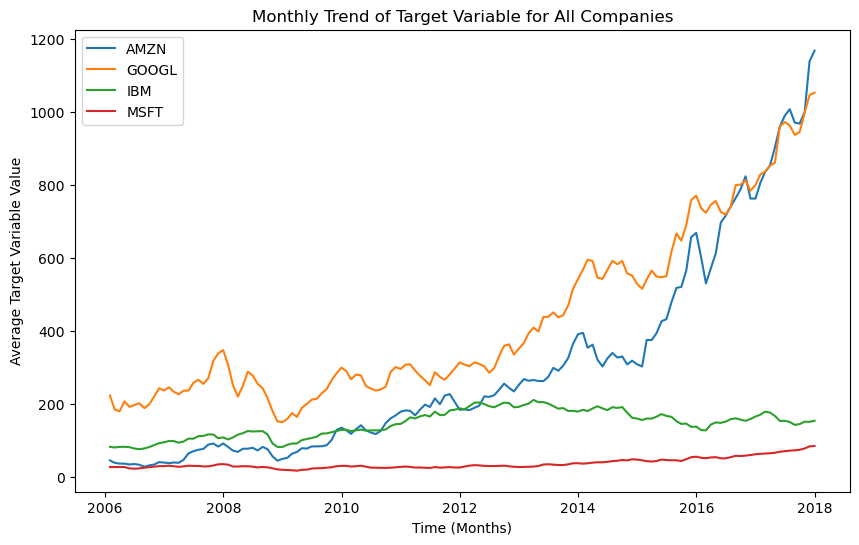

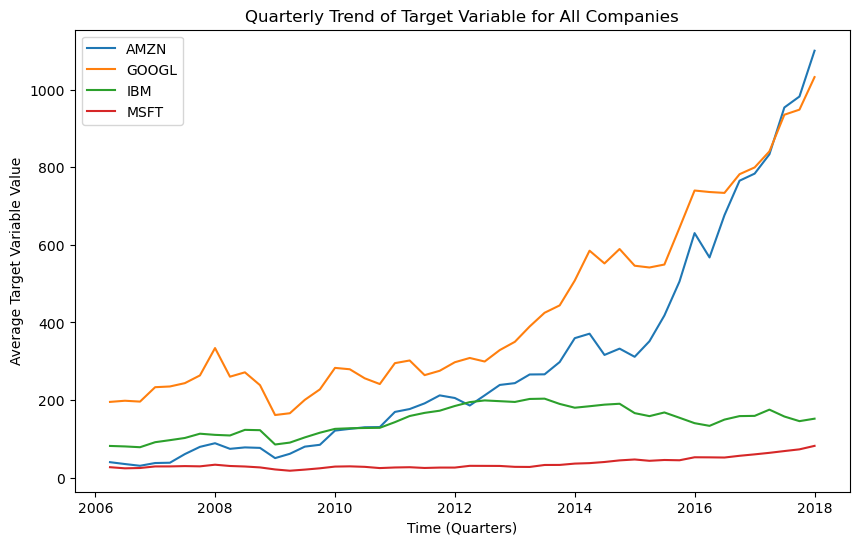

In [27]:
# Lets check the pattern with different sequence lengths

# Make Date as DateTime object and set as Index
if not isinstance(stock_df.index, pd.DatetimeIndex):
    stock_df['Date'] = pd.to_datetime(stock_df['Date'], dayfirst=True) # Setting dayfirst to True as per input format
    stock_df.set_index('Date', inplace=True)

# 1. Check Daily Trend
plt.figure(figsize=(10, 6))
for company_name in stock_df['Name'].unique():
    company_data = stock_df[stock_df['Name'] == company_name]
    target_variable = company_data['Close']
    plt.plot(target_variable.index, target_variable.values, label=company_name)
plt.title('Daily Stock Trend for all Companies')
plt.xlabel('Time (Days)')
plt.ylabel('Target Variable Value')
plt.legend()
plt.show()

# 2. Weekly Trend
plt.figure(figsize=(10, 6))
for company_name in stock_df['Name'].unique():
    company_data = stock_df[stock_df['Name'] == company_name]
    target_variable = company_data['Close']
    weekly_data = target_variable.resample('W').mean()
    plt.plot(weekly_data.index, weekly_data.values, label=company_name)
plt.title('Monthly treba if target variable for all Companies')
plt.xlabel('Time (Weeks)')
plt.ylabel('Average Target Variable Value')
plt.legend()
plt.show()

# 3. Monthly Trend
plt.figure(figsize=(10, 6))
for company_name in stock_df['Name'].unique():
    company_data = stock_df[stock_df['Name'] == company_name]
    target_variable = company_data['Close']
    monthly_data = target_variable.resample('M').mean()
    plt.plot(monthly_data.index, monthly_data.values, label=company_name)
plt.title('Monthly Trend of Target Variable for All Companies')
plt.xlabel('Time (Months)')
plt.ylabel('Average Target Variable Value')
plt.legend()
plt.show()

# 4. Quarterly Trend
plt.figure(figsize=(10, 6))
for company_name in stock_df['Name'].unique():
    company_data = stock_df[stock_df['Name'] == company_name]
    target_variable = company_data['Close']
    quarterly_data = target_variable.resample('Q').mean()
    plt.plot(quarterly_data.index, quarterly_data.values, label=company_name)
plt.title('Quarterly Trend of Target Variable for All Companies')
plt.xlabel('Time (Quarters)')
plt.ylabel('Average Target Variable Value')
plt.legend()
plt.show()


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [28]:
# Create data instances from the master data frame using decided window size and window stride
#Lets set the target names to one of the stocks (e.g., ['AMZN', 'GOOGL', 'IBM', 'MSFT'])
target_names = ['AMZN']
window_size = 60  # Optimal window size (e.g., 60 days)
step_size = 5  # Step size (e.g., 5 days)
test_size = 0.2  # Proportion of data for testing (e.g., 20%)

# Call create_split function to generate training and testing data
X_train, X_test, y_train, y_test, X_scaler, y_scaler = create_split(
    stock_df, target_names, window_size, step_size, test_size
)

In [29]:
# Check the number of data points generated
len(X_train), len(X_test), len(y_train), len(y_test)

(1922, 481, 1922, 481)

**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [30]:
# Check if the datasets are compatible inputs to neural networks
print("PRINT DATA SET SHAPES")
print('-'*30)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("\n"+'-'*30)

PRINT DATA SET SHAPES
------------------------------
X_train shape: (1922, 60, 5)
y_train shape: (1922, 1)
X_test shape: (481, 60, 5)
y_test shape: (481, 1)

------------------------------


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [31]:
# Create a function that creates a simple RNN model according to the model configuration arguments
#We will use activation = 'tanh' and 'adam' optimizer
def createSimpleRNNModel(input_shape, units=64, activation='tanh', optimizer='adam'):

    #initialize the model and ass tje SimpleRNN model and Dense output layer
    model = Sequential()
    model.add(SimpleRNN(units, activation=activation, input_shape=input_shape))
    model.add(Dense(1))  # Output layer with 1 unit for regression

    model.compile(loss='mse', optimizer=optimizer)  # Compile with MSE loss and specified optimizer
    return model

In [33]:
# Get timesteps and features from X_train shape
input_shape = X_train.shape[1:]

# Create the model
model = createSimpleRNNModel(input_shape)

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [35]:
# Find an optimal configuration of simple RNN
# Define the function to create the RNN model
def createRNNModel(config):
    model = Sequential()
    model.add(SimpleRNN(units=config['units'], activation=config['activation'], input_shape=input_shape))
    model.add(Dense(1))  # Output layer with 1 unit for regression
    return model


In [36]:
# Find the best configuration based on evaluation metrics
# Input shape for the model
input_shape = X_train.shape[1:]

# Hyperparameter configurations
configurations = [
    {'name': 'RNN_Config_1', 'units': 32, 'activation': 'tanh'},
    {'name': 'RNN_Config_2', 'units': 64, 'activation': 'relu'},
    # Add more configurations as needed
]

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [38]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
epochs = 10
batch_size = 32
history_dict = {}
best_mse = float('inf')
best_config = None

for config in configurations:
    model = createRNNModel(config)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    history_dict[config['name']] = history.history

    # Evaluate on the validation set
    loss, mae = model.evaluate(X_test, y_test, verbose=0)

    print(f"Configuration: {config['name']}")
    print(f"Validation Loss (MSE): {loss}, Validation MAE: {mae}")
    print("-" * 30)

    # Update best configuration if current one is better (lower MSE)
    if loss < best_mse:
        best_mse = loss
        best_config = config
        best_model = model  # Store the best model

# Print the best configuration and its results
print("Best Configuration:", best_config)
print("Best Validation Loss (MSE):", best_mse)

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Inverse transform predictions and actual values if you scaled the target variable
y_test_actual = y_scaler.inverse_transform(y_test)
y_pred_actual = y_scaler.inverse_transform(y_pred)

# Calculate and print other evaluation metrics for the best model
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

print("Best Model Performance:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)


Configuration: RNN_Config_1
Validation Loss (MSE): 5.926052472204901e-05, Validation MAE: 0.005177359562367201
------------------------------
Configuration: RNN_Config_2
Validation Loss (MSE): 4.480847201193683e-05, Validation MAE: 0.004133317153900862
------------------------------
Best Configuration: {'name': 'RNN_Config_2', 'units': 64, 'activation': 'relu'}
Best Validation Loss (MSE): 4.480847201193683e-05
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Best Model Performance:
Mean Squared Error (MSE): 62.227402957751856
Root Mean Squared Error (RMSE): 7.888434759681534
R-squared (R2): 0.9988268489576627


Plotting the actual vs predicted values

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


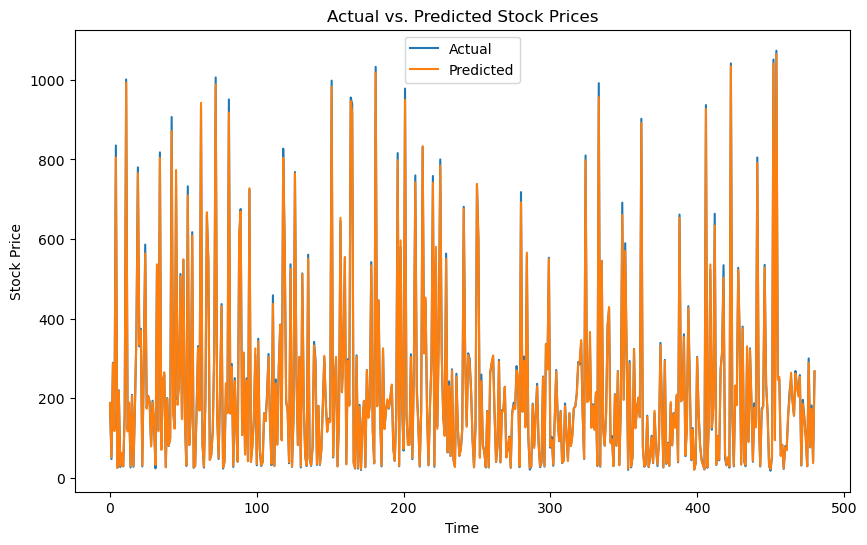

In [40]:
# Predict on the test data and plot
# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Inverse transform predictions and actual values if you scaled the target variable
y_test_actual = y_scaler.inverse_transform(y_test)
y_pred_actual = y_scaler.inverse_transform(y_pred)

# Plotting the actual vs. predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [42]:
# Compute the performance of the model on the testing data set
# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Inverse transform predictions and actual values if you scaled the target variable
y_test_actual = y_scaler.inverse_transform(y_test)
y_pred_actual = y_scaler.inverse_transform(y_pred)

# Calculate and print evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print("Performance on TEST data set:")
print('-' * 30)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)
print('-' * 30)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Performance on TEST data set:
------------------------------
Mean Squared Error (MSE): 56.20707567480902
Root Mean Squared Error (RMSE): 7.4971378321869615
R-squared (R2): 0.9989403480415309
Mean Absolute Error (MAE): 4.544864952737723
------------------------------


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [41]:
# # Define a function to create a model and specify default values for hyperparameters
def createGRUModel(input_shape, units=64, activation='tanh',
                              optimizer='adam', dropout_rate=0.2, recurrent_dropout_rate=0.2):

    #Initialize the model
    model = Sequential()

    # Add GRU layer to the model
    model.add(GRU(units, activation=activation, dropout=dropout_rate,
                   recurrent_dropout=recurrent_dropout_rate, input_shape=input_shape))

    # Add Dense output layer to the model
    model.add(Dense(1))  # Output layer with 1 unit for regression

    # Compile the model
    model.compile(loss='mse', optimizer=optimizer)

    return model

In [47]:
# Get the input shape from your training data
input_shape = X_train.shape[1:]

# Create a GRU model with default hyperparameters
model = createGRUModel(input_shape)

# with custom hyperparameters
model = createGRUModel(input_shape, units=128, activation='relu', dropout_rate=0.3)

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [48]:
# Find an optimal configuration
best_params = {
    'units': 128,
    'activation': 'relu',
    'dropout_rate': 0.3,
    'recurrent_dropout_rate': 0.2,
    'learning_rate': 0.001
}


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [49]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# 1. Define the model creation function
def createGRUModel(input_shape):
    model = Sequential()
    model.add(GRU(units=128,
                  activation='relu',
                  dropout=0.3,
                  recurrent_dropout=0.2,
                  input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# 2. Build and train the model
input_shape = X_train.shape[1:]
model = createGRUModel(input_shape)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                    verbose=1)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 0.0133 - val_loss: 0.0066
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.0024 - val_loss: 0.0060
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 7.1178e-04 - val_loss: 0.0066
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 9.9908e-04 - val_loss: 0.0061
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 7.0418e-04 - val_loss: 0.0065
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 9.8227e-04 - val_loss: 0.0064
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 3.8657e-04 - val_loss: 0.0065


In [50]:
# Compute the performance of the model on the testing data set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE Loss: {test_loss:.4f}")

Test MSE Loss: 0.0065


Plotting the actual vs predicted values

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Test RMSE: 0.0806


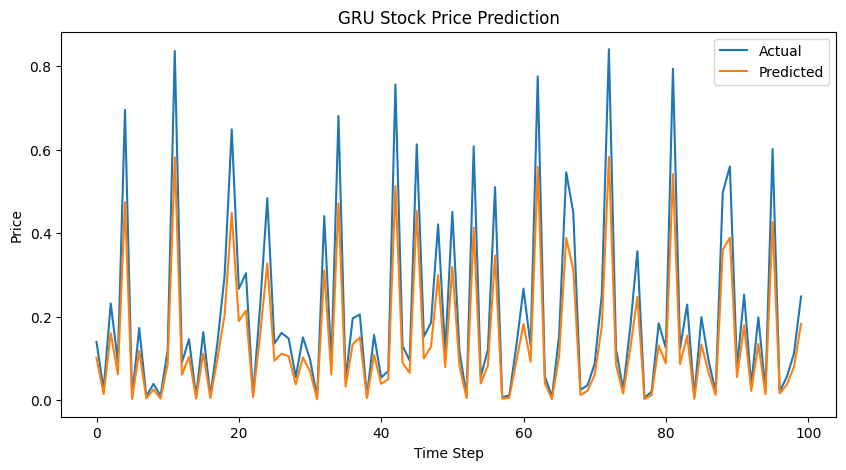

In [51]:
# Predict on the test data
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")


plt.figure(figsize=(10,5))
plt.plot(y_test[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title('GRU Stock Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

## Conclusion and Insights
### The Frequency distribution of volume shows that, for all stocks:
- There is low to moderate volume on most of the trading days
- There are some outliers i.e. very high volumes but that is rare.
- For Amazon, majority of days see low volume. Very few unusually high volume.
- IBM has more uniform spread compared to other stocks.
- Microsoft is the most variably traded stock.

### The trend analysis of the stocks over the years shows that:
- Amazon and Google has a strong upward trend over the years, this shows a strong performance by these stocks.
- Amazon is bit volatile due to some sharp fluctuations whereas Google is less volatile and shows steady growth.
- IBM has a very slow growth till 2013 and post that showing a decline. This is under-performance compared to peers.
- Microsoft shows slow and steady growth with less volatility.

#### Final Takeaways from above analysis:
- Investors favor AMAZON and GOOGLE for long-term capital appreciation.
- MICROSOFT demonstrates reliable late-stage growth, ideal for stable portfolios.
- IBM lags behind — shows a decline or stagnation requiring relook into investment strategies.

### Simple RNN model
We built a simple RNN model with output shape of (None, 64) and 4480 parameters. We used a Dense layer in Layer2 with 65 parameters and output shape of (None, 64). One neuron was used for binary classification.

### GRU Model
We built a GRU-based neural network and performed hyperparameter tuning by adjusting units, activation functions, dropout values, and learning rates. After testing different combinations, the best performance came from the model with 128 GRU units, ReLU activation, 0.3 dropout, and a 0.001 learning rate.

